In [2]:
%load_ext autoreload
%autoreload 2

# Basic Examples

The `dukes100nm_glycerol` folder contains three time series of 100nm (diameter) SiO2 nanoparticles dispersed in a glycerol-water mixture. 

This tutorial shows how to:
1. Load data and define the setup.
2. Process the datasets and calculate:
    * The azimuthally integrated SAXS curves
    * XPCS intensity auto-correlation functions
    * XSVS photon statistics
3. Display and fit the correlation functions.
4. Working with the database:
    * Display entries
    * Select measurements
    * Discard measurements
5. Determine the viscosity of the solution.

**Importing Xana and Setting up the Figure Style**

In [1]:
from Xana import Xana

import numpy as np
import seaborn as sns

sns.set_style('ticks', rc={'figure.dpi':300})
sns.set_context('notebook')

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')

ModuleNotFoundError: No module named 'Xana'

## Downloading Data

In [5]:
!wget https://github.com/reiserm/Xana_example/raw/master/xpcs_data.tgz -O xpcs_data.tgz -q

In [6]:
import hashlib
hashlib.md5(open('xpcs_data.tgz','rb').read()).hexdigest()

'76022d60f4a367ff38e8c515b2e3c61c'

In [7]:
!tar -xzf xpcs_data.tgz

# Xfmt

In [6]:
from Xana.ProcData.Xfmt import Xfmt

In [7]:
xformat = Xfmt()
supported = xformat.SUPPORTED
print(supported)

for fmtstr in supported:
    d = Xana(fmtstr=fmtstr, # format string that defines how the date are read
         sample='100nm-SiO2', # optional: sample name used in data base
         maskfile='./mask_array.npy', # optional: file that conatains the blemish / mask
         detector='eiger500k') # specify the detector

['id10_eiger_single_edf', 'pilatus_single_cbf', 'p10_eiger_h5', 'converted_h5', 'lambda_nxs', 'id02_eiger_single_edf', 'id02_eiger_multi_edf', 'ebs_id02_h5', 'ebs_id02_eiger2', 'ebs_id02_eiger500k', 'ebs_id10_h5']


# Loading Data and Defineing the Setup

For each type of analysis a *setupfile* is required that contains information about the geometry (sample-detector distance, wavelength, etc.) but also about the ROIs where the XPCS and XSVS analysis will be performed.

In [18]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how the date are read
         sample='100nm-SiO2', # optional: sample name used in data base
         maskfile='./mask_array.npy', # optional: file that conatains the blemish / mask
         detector='eiger500k') # specify the detector

In [19]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir
0,1,0.00032,0.00001,0.0,1500,0,1499,/gpfs/exfel/data/user/reiserm/Xana/docs/source...,/gpfs/exfel/data/user/reiserm/Xana/docs/source...
1,2,0.00032,0.00001,0.0,1500,0,1499,/gpfs/exfel/data/user/reiserm/Xana/docs/source...,/gpfs/exfel/data/user/reiserm/Xana/docs/source...
2,3,0.00032,0.00001,0.0,1500,0,1499,/gpfs/exfel/data/user/reiserm/Xana/docs/source...,/gpfs/exfel/data/user/reiserm/Xana/docs/source...


In [21]:
data = d.get_series(0, method='full', verbose=True, first=1, last=100)
print('The returned array has the dimensions: ', data.shape)

First images is:  1
Last image is:  100
Loading data in chunks of 256 images.
[============================================================] 100.0%..
The returned array has the dimensions:  (100, 514, 1030)


To define the ROIs for the XPCS/XSVS analysis, the data are averaged over the time axis. The command is the same except the `method`-keyword has been changed to `'average'`. Then, the function returns a list containing the average intensity, `I`, and the variance, `V`.

In [26]:
avr = d.get_series(0, method='average', verbose=True, first=1, last=100)
assert len(avr) == 2

evts = d.get_series(0, method='events', verbose=True, first=1, last=100)
assert len(evts) == 2

First images is:  1
Last image is:  100
Loading data in chunks of 256 images.
[============================================================] 100.0%..
First images is:  1
Last image is:  100
Loading data in chunks of 256 images.
Qrois not defined. Using all pixels that are not masked.
[============================================================] 100.0%..


Now the setup can be defined. If no dictionary is passed to the `make_setup` method, the user is prompted to input the parameters. The vector `qv_init` contains a list of tuples. Each tuple should have the q position (or an array of q positions) as first element and the q width as second argument.

The `defineqrois` method requires an image, `I`, and the `qv_init` list as input parameters. Using the `phiv_init` keyword, angular slices (in degrees) can be selected.

Added the following Q-values [nm-1]:
[0.025 0.025 0.03  0.03  0.035 0.035 0.04  0.04  0.045 0.045 0.05  0.05
 0.055 0.055 0.06  0.06  0.065 0.065 0.07  0.07  0.075 0.075 0.125 0.125]


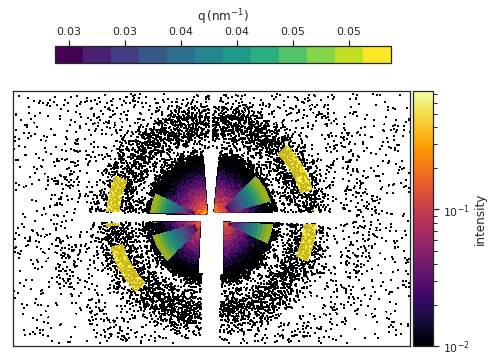

Added the following Q-values [nm-1]:
[0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.125]


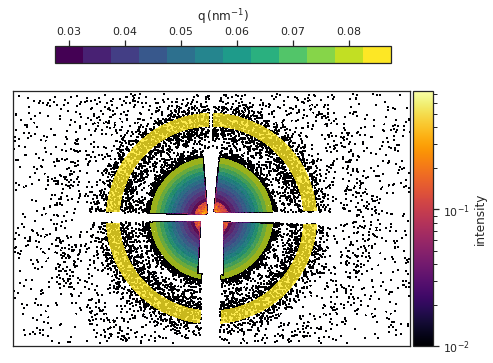

In [28]:
d.setup.make(**{'center': [516, 257], # position of the direct beam in pixels
                'wavelength': 1.5, # X-ray wavelength in Angstrom
                'distance': 5 # sample-detector distance in m
               }
            )

# q-vector and width in nm-1
qv_init = [(np.arange(0.025, 0.08, .005), .008),
           (.125, .02)]

# anglular slices in degress (10, 150) with a width of 30 degrees
phiv_init = [([10, 150], 30)]

I, V = avr
d.defineqrois(I, qv_init=qv_init, plot='ROIS', d=400, mirror=True, phiv_init=phiv_init,)
d.defineqrois(I, qv_init=qv_init, plot='ROIS', d=400,)

The setup can be saved to load it from different notebooks or scripts. The `maksavdir` method can be used to create directories for saving setupfiles or other results. It creates a new subfolder `setupfiles` (first argument) in the folder specified by the second argument, here in the present folder `./`. Prefix and suffix are added automatically. If a file with the same name already exists, the user is asked if he or she wants to override it.

In [29]:
d.mksavdir('tests-setupfiles', './')
d.savesetup('setup_100nm', handle_existing='overwrite')

Changing savdir to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-setupfiles/
Try loading database:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-setupfiles/analysis_database.pkl
Successfully loaded database

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-setupfiles/setup_100nm.pkl


In [34]:
d.init_db('tests-setupfiles/analysis_database.pkl', handle_existing='overwrite')


Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-setupfiles/analysis_database.pkl


# Processing Data

We follow the same steps as before to initialize a Xana instance; however, now we load the previously defined and saved setupfile. 

In [42]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how data are read
         sample='100nm-SiO2', # optional: sample name used in data base
         setupfile='./tests-setupfiles/setup_100nm.pkl',) # we load the previously defined setup

Loaded setupfile:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-setupfiles/setup_100nm.pkl.


The setupfile can also be loaded separately:

In [43]:
d.loadsetup('./tests-setupfiles/setup_100nm.pkl')

Loaded setupfile:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-setupfiles/setup_100nm.pkl.


Again we connect Xana to the directory containing the data:

In [44]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir
0,1,0.00032,0.00001,0.0,1500,0,1499,/gpfs/exfel/data/user/reiserm/Xana/docs/source...,/gpfs/exfel/data/user/reiserm/Xana/docs/source...
1,2,0.00032,0.00001,0.0,1500,0,1499,/gpfs/exfel/data/user/reiserm/Xana/docs/source...,/gpfs/exfel/data/user/reiserm/Xana/docs/source...
2,3,0.00032,0.00001,0.0,1500,0,1499,/gpfs/exfel/data/user/reiserm/Xana/docs/source...,/gpfs/exfel/data/user/reiserm/Xana/docs/source...


As each run of the analysis routines creates a separate file, we want to create a new directory for the results. Again we can use the `mksavdir` command.

In [45]:
d.mksavdir('tests-results', './') 

Changing savdir to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/
Try loading database:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl
Initialize database...

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


The results of the analysis are stored (pickled) as dictionaries containing all necessary information on the analysis. Additionally, an entry is added in the analysis **database**. The default file is `Analysis_db.pkl`. If that file does not exist, the database has to be initialized **after** connecting with a dataset. That is because the columns of the database are taken from the metadata table.

Different types of analysis can be performed as shown in the next cell using the `analyze` method.
* As for loading the data, the first argument is the index of the metadata table and defines the series you want to analyze. -1 means that every series of the metadata tabel is analyzed.
* The second argument defines the type of analysis:
    * **xpcs** uses pyxpcs to calcualte intensity auto-correlation functions
    * **xpcs_evt** uses the eventcorrelator to calculate correlation functions
    * **saxs** computes the azimuthally integrated intensity
    * **xsvs** calculates the photon probabilities
* Other kwargs are specific for a specific type of analysis. Again the reader is refferred to the [Xana Documentation](https://xana.readthedocs.io/en/latest/) for further information.

**SAXS Azimuthal Intensity**

In [46]:
d.analyze(-1, 'saxs', verbose=True, first=1, last=50)



#### Starting saxs Analysis ####
Series: 0 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/s0001_0000.pkl

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


#### Starting saxs Analysis ####
Series: 1 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/s0002_0001.pkl

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


#### Starting saxs Analysis ####
Series: 2 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results

**XPCS Correlation Functions**

In [47]:
d.analyze(-1, 'xpcs', verbose=True, first=1, twotime_par=1, last=200)



#### Starting xpcs Analysis ####
Series: 0 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.
Number of images is: 199
shape of image section is: (429, 430)
Number of ROIs:  12
Using 2 processes.
Number of registers is 5 with 48 total correlation points.
[============================================================] 100.0%..
Finished calculating correlation functions.
Start calculating TRC and Chi4...
Elapsed time: 0.03 min

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/s0001_0003.pkl

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


#### Starting xpcs Analysis ####
Series: 1 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.
Number of images is: 199
shape of image section is: (429, 430)
Number of ROIs:  12
Using 2 processes.
Number of registe

**XPCS Eventcorrelator**

In [48]:
d.analyze(-1, 'xpcs_evt', verbose=True, first=1, twotime_par=1, last=200)



#### Starting xpcs_evt Analysis ####
Series: 0 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.
First images is:  1
Last image is:  199
Loading data in chunks of 200 images.
[============================================================] 100.0%..

Running eventcorrelator

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/s0001_0006.pkl

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


#### Starting xpcs_evt Analysis ####
Series: 1 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.
First images is:  1
Last image is:  199
Loading data in chunks of 200 images.
[============================================================] 100.0%..

Running eventcorrelator

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/s0002_0007.pkl

**XSVS Photon Probabilities**

In [49]:
d.analyze(-1, 'xsvs', verbose=True, first=1, nbins=64, nprocs=4, last=200)



#### Starting xsvs Analysis ####
Series: 0 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.
Number of images is: 199
Loading data in chunks.
Number of ROIs:  12
Using 4 processes.
[============================================================] 100.0%..
Finished calculating correlation functions.
Elapsed time: 0.01 min
Elapsed time for calulating probabilities: 0.01 min

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/s0001_0009.pkl

Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


#### Starting xsvs Analysis ####
Series: 1 in folder /gpfs/exfel/data/user/reiserm/Xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0

Using 1 processes to read data.
Number of images is: 199
Loading data in chunks.
Number of ROIs:  12
Using 4 processes.
[============================================================] 100.0%..
Finished calcu

## The Database

The results are storred in the previously defined `'100nm_glycerol'` directory. We see the file of the analysis database `Analysis_db.pkl` and a file for each analysis type and dataset (9 files in total). The file name starts with the name of the performed analysis type (saxs, xpcs, xsvs,...).

In [50]:
from Xana import Xana

In [ ]:
d = Xana(setupfile='./tests-setupfiles/setup_100nm.pkl')
print(d)
d.load_db('./tests-results/analysis_database.pkl')

# the database
d.db

In [61]:
d.save_db('./tests-results/analysis_database.pkl', handle_existing='overwrite')


Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


# Data Interpretation

The `Xana` module provides different submodules for data interpretation. In particular:
* `Soq` for displaying SAXS data.
* `CorrFunc` for analyising XPCS correlation functions.
* `VisbFunc` for plotting photon statistics.

## Loading Data Base

In [62]:
from Xana import Xana

In [ ]:
d = Xana(setupfile='./tests-setupfiles/setup_100nm.pkl')
d.load_db('./tests-results/analysis_database.pkl')

The database can be accessed by the `db` attribute of the Xana instance.

## SAXS

In [64]:
from Xana import Soq

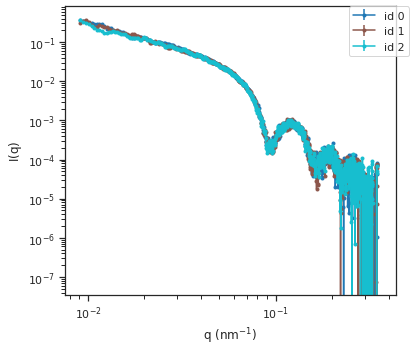

In [66]:
s = Soq(d)
db = d.db[d.db['analysis']=='saxs']
s.plot_soq(db.index, Ae=0)

## XPCS

In [67]:
from Xana import CorrFunc
import numpy as np

In [68]:
d.db['use'] = True

Merged g2 functions:  [0.00032] (exposure times)
                      [3] (number of correlation functions)
                      [597] (total number of images)
Fit successful: True


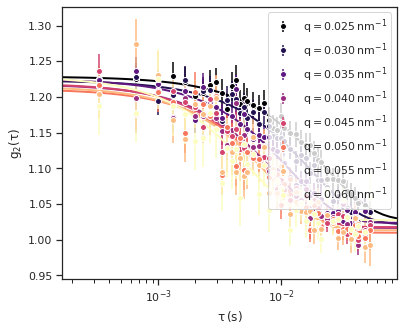

In [69]:
# initializing CorrFunc instance
g = CorrFunc(d)

# searching data base for xpcs measurements
ind = d.db[(d.db['analysis'] == 'xpcs')
          &(d.db['use'] == True)].index.values

#loading correlation functions
g.get_g2(ind, merge='merge')

# plotting
g.nq = np.arange(8)
g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1, fix={}, init={'t0':(.02,0, None)}, 
          fitglobal=['g0','beta'])

In [70]:
d.discard_entry(3)


Results saved to:
	/gpfs/exfel/data/user/reiserm/Xana/docs/source/tests-results/analysis_database.pkl


In [71]:
g.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

Fit successful: True


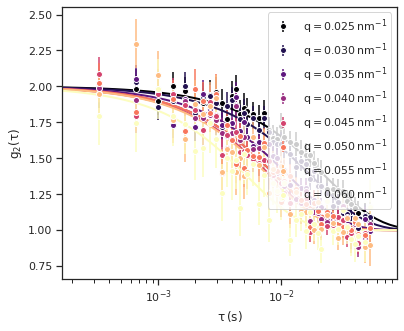

In [72]:
g.plot_g2(doplot='data_fit_legq', dofit=True, 
          fix={'a':1, 'g0':1, 'beta':1},)# init={'beta':(1,0,1), 't0':(.01,None,None), 'g0':(1,None,None)})

## Eventcorrelator

Merged g2 functions:  [0.00032] (exposure times)
                      [3] (number of correlation functions)
                      [597] (total number of images)
Fit successful: True


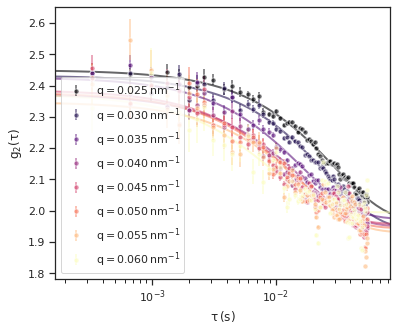

In [73]:
ge = CorrFunc(d)
ind = d.db[(d.db['analysis']=='xpcs_evt')
          &(d.db['use'])].index.values
ge.get_g2(ind, merge='merge')
ge.nq = np.arange(8)
ge.plot_g2(doplot='data_fit_legq', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0, init={'a':(2,None,None)})

In [74]:
ge.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

Fit successful: True


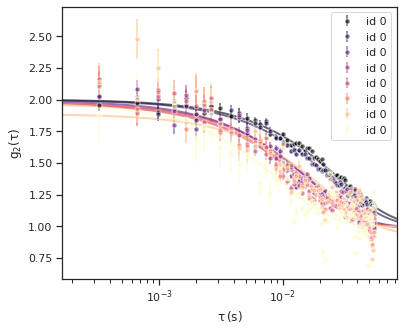

In [75]:
ge.plot_g2(doplot='data_fit_legd', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

### Comparing results from pyxpcs and eventcorrelator

In [76]:
gs = g + ge

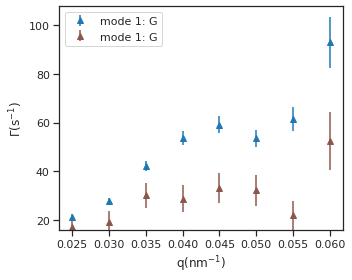

In [77]:
gs.plot_parameters(['G'], modes=(1,))

**Remark**: From here, the documentation is work-in-progress and gives some examples of additional features.

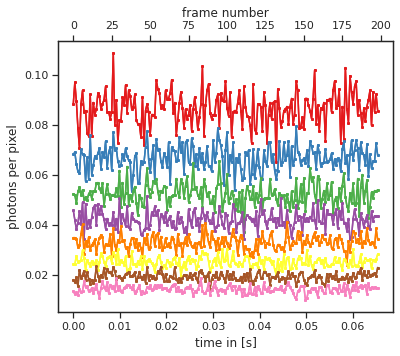

In [78]:
g.plot_trace(4)

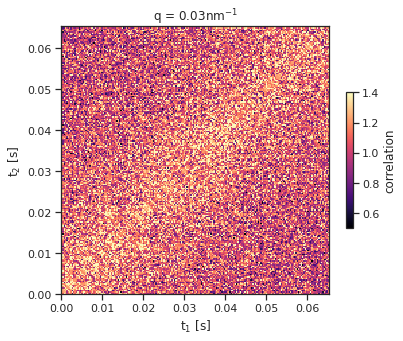

In [79]:
g.plot_twotime([3,4,5], interpolation='nearest', clim=(0.5,1.4), twotime_par=1)

## XSVS

In [80]:
from Xana import VisbFunc

Loaded probabilities of 3 series.


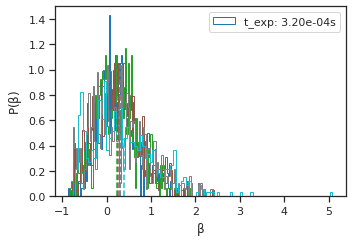

In [81]:
# initializing Visibility Func instance
v = VisbFunc(d)

# searching data base for xsvs results
ind = d.db[(d.db['analysis']=='xsvs')
          &(d.db['use'])].index.values

# loading probablities
v.get_prob(ind, merge=True)

# calculating contrast
v.calculate_contrast()

# plot histogram
v.quicklook(plot=['pbb'], nq=np.arange(5), color_mode=0, ratio=0, cmap='tab10', alpha=0.2)  

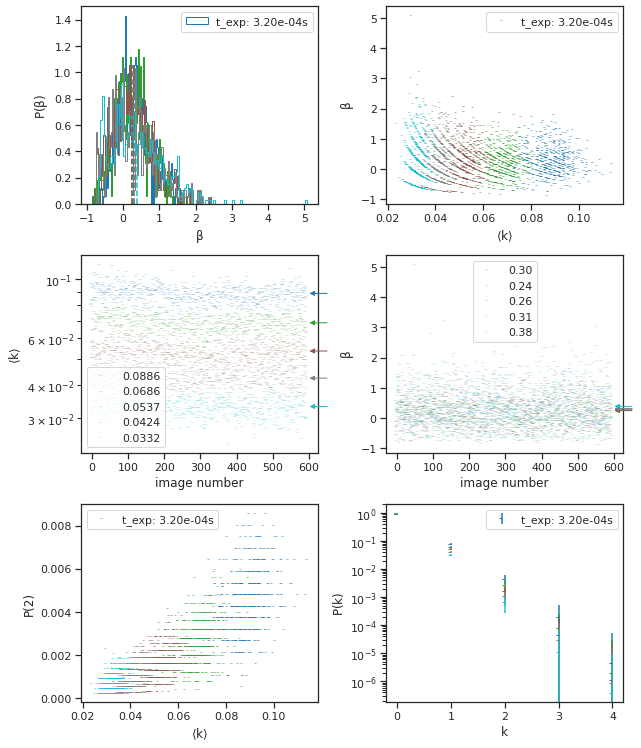

In [82]:
v.quicklook(plot=['pbb','bvkb', 'kbvi', 'bvi', 'pkvkb', 'pbk'],
                      idx=None, nq=np.arange(5), change_marker=0,
                       color_mode=1, maxlen=np.inf, ratio=0, probk=2,
                       cmap='tab10', lfs=8, total_counts=False, alpha=0.2)